In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Loading the data
df = pd.read_csv("test_df.csv")
preds_df = pd.read_csv("predictions.csv")

df = df.merge(
    preds_df[["transaction_id", "score", "prediction"]],
    on="transaction_id",
    how="left"
)


In [3]:
tx_id = 36108

features = [
    "trans_date_trans_time",
    "is_fraud",
    "prediction", "score", 

    # Transaction features
    "amt",
    "hour",
    "is_night_tx",
    "dayofweek",
    "is_weekend",
    "age",
    "is_new_merchant",
    "card_time_since_prev_tx",
    "dist_from_prev_tx",
    "dist_from_home",
    "is_impossible_travel",
    "category_idx",
    "is_category_shift",

    # Card features
    "amt_zscore",
    "amt_vs_card_mean_ratio",
    "amt_minus_prev_max",
    "amt_minus_prev_min",
    "card_amt_mean",
    "card_amt_std",
    "tx_count_1h",
    "tx_count_24h",
    "amt_sum_1h",
    
    # Identity
    "gender_idx", "job_idx",
    "city_pop",

    # Mercahnt feature
    "merchant_avg_amt",
    "merchant_time_since_prev_tx",
    "amt_vs_merchant_avg_ratio",
]

df.loc[df["transaction_id"] == tx_id, features].iloc[0].to_frame("value")

,value
trans_date_trans_time,2020-07-03 22:56:41
is_fraud,1
prediction,0
score,0.0
amt,10.32
hour,22
is_night_tx,0
dayofweek,4
is_weekend,0
age,76.093087


In [4]:
row_fn = df.loc[df["transaction_id"] == tx_id].iloc[0]
card_id = row_fn["card_id"]
fraud_time = row_fn["unix_trans_time"]

# Keep only past transactions
card_tx = (
    df[
        (df["card_id"] == card_id) &
        (df["unix_trans_time"] < fraud_time)
    ]
    .sort_values("unix_trans_time")[features]
)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
card_tx

,trans_date_trans_time,is_fraud,prediction,score,amt,hour,is_night_tx,dayofweek,is_weekend,age,is_new_merchant,card_time_since_prev_tx,dist_from_prev_tx,dist_from_home,is_impossible_travel,category_idx,is_category_shift,amt_zscore,amt_vs_card_mean_ratio,amt_minus_prev_max,amt_minus_prev_min,card_amt_mean,card_amt_std,tx_count_1h,tx_count_24h,amt_sum_1h,gender_idx,job_idx,city_pop,merchant_avg_amt,merchant_time_since_prev_tx,amt_vs_merchant_avg_ratio
169696,2020-07-02 23:17:05,1,0,0.691357,9.03,23,0,3,0,76.090349,1,3600.0,0.000000,109.421187,0,9,0,0.000000,0.091538,-573.75,-10.94,98.648088,96.974093,1.0,6.0,76.31,0,167,6263,98.000698,26021.0,0.092142
169697,2020-07-03 00:18:13,1,0,0.690636,286.73,0,1,4,0,76.093087,1,3668.0,186.959987,80.762966,0,4,1,0.000000,31.753042,277.70,277.70,9.030000,0.000000,1.0,1.0,9.03,0,167,6263,106.930588,54790.0,2.681459
169698,2020-07-03 02:07:47,1,1,0.796201,262.49,2,1,4,0,76.093087,1,6574.0,119.523764,41.310906,0,4,0,0.583662,1.775020,-24.24,253.46,147.880000,196.363553,1.0,2.0,286.73,0,167,6263,114.128438,4549.0,2.299953
169699,2020-07-03 22:31:00,1,0,0.451244,1115.94,22,0,4,0,76.093087,1,73393.0,21.775380,24.259385,0,11,1,6.045452,5.996991,829.21,1106.91,186.083333,153.810944,1.0,3.0,262.49,0,167,6263,75.264000,5275.0,14.827009


In [5]:
# Total transactions
total_tx = card_tx.shape[0]

# Number of frauds
num_fraud = card_tx["is_fraud"].sum()

# Percentage
perc_fraud = (num_fraud / total_tx) * 100

print(f"Percentage of fraud transactions: {perc_fraud:.2f}%")


Percentage of fraud transactions: 100.00%


In [6]:
# Last transaction (fraud)
fn_tx = row_fn

# Compute historical stats
hist_stats = card_tx[[
    "amt", "amt_zscore", "amt_minus_prev_max", "amt_minus_prev_min", "card_time_since_prev_tx", "dist_from_prev_tx", "dist_from_home","merchant_avg_amt", "merchant_time_since_prev_tx"
]].describe().T

# Add the FN transaction value
hist_stats["fn_tx"] = [
    fn_tx["amt"],
    fn_tx["amt_zscore"],
    fn_tx["amt_minus_prev_max"],
    fn_tx["amt_minus_prev_min"],
    fn_tx["card_time_since_prev_tx"],
    fn_tx["dist_from_prev_tx"],
    fn_tx["dist_from_home"],
    fn_tx["merchant_avg_amt"],
    fn_tx["merchant_time_since_prev_tx"]
]

hist_stats

,count,mean,std,min,25%,50%,75%,max,fn_tx
amt,4.0,418.547500,481.591348,9.030000,199.125000,274.610000,494.032500,1115.940000,10.320000
amt_zscore,4.0,1.657279,2.938359,0.000000,0.000000,0.291831,1.949110,6.045452,-0.847664
amt_minus_prev_max,4.0,127.230000,585.870652,-573.750000,-161.617500,126.730000,415.577500,829.210000,-1105.620000
amt_minus_prev_min,4.0,406.782500,484.713209,-10.940000,187.360000,265.580000,485.002500,1106.910000,1.290000
card_time_since_prev_tx,4.0,21808.750000,34417.426994,3600.000000,3651.000000,5121.000000,23278.750000,73393.000000,1541.000000
dist_from_prev_tx,4.0,82.064783,87.131356,0.000000,16.331535,70.649572,136.382819,186.959987,72.373821
dist_from_home,4.0,63.938611,38.462872,24.259385,37.048026,61.036936,87.927521,109.421187,68.825489
merchant_avg_amt,4.0,98.580931,16.886461,75.264000,92.316523,102.465643,108.730051,114.128438,87.861600
merchant_time_since_prev_tx,4.0,22658.750000,23621.175251,4549.000000,5093.500000,15648.000000,33213.250000,54790.000000,29338.000000


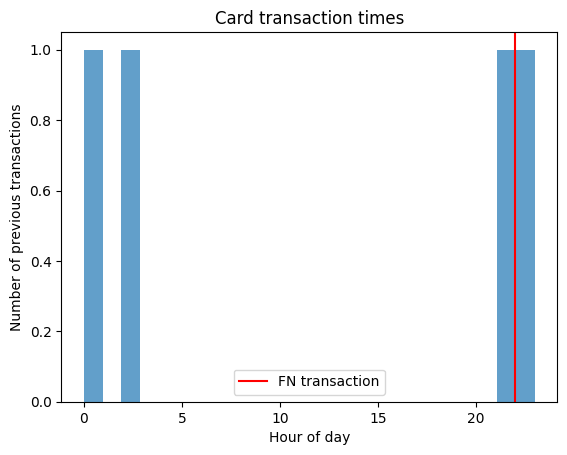

In [7]:
plt.hist(card_tx["hour"], bins=24, alpha=0.7)
plt.axvline(fn_tx["hour"], color="red", label="FN transaction")
plt.xlabel("Hour of day")
plt.ylabel("Number of previous transactions")
plt.title("Card transaction times")
plt.legend()
plt.show()


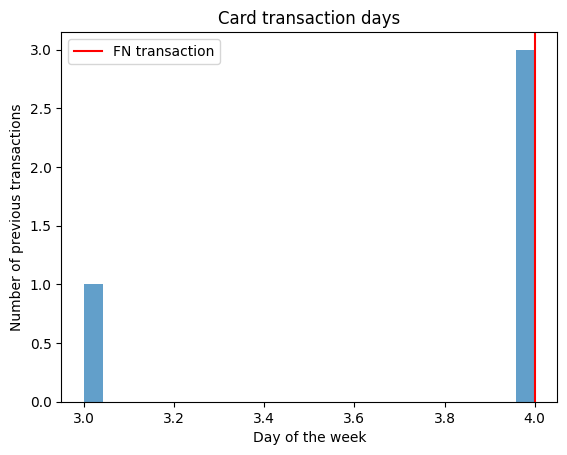

In [8]:
plt.hist(card_tx["dayofweek"], bins=24, alpha=0.7)
plt.axvline(fn_tx["dayofweek"], color="red", label="FN transaction")
plt.xlabel("Day of the week")
plt.ylabel("Number of previous transactions")
plt.title("Card transaction days")
plt.legend()
plt.show()
